##### Copyright 2020 The TensorFlow Authors.

In [1]:
#@title Licensed under the Apache License, Version 2.0 (the "License");
# you may not use this file except in compliance with the License.
# You may obtain a copy of the License at
#
# https://www.apache.org/licenses/LICENSE-2.0
#
# Unless required by applicable law or agreed to in writing, software
# distributed under the License is distributed on an "AS IS" BASIS,
# WITHOUT WARRANTIES OR CONDITIONS OF ANY KIND, either express or implied.
# See the License for the specific language governing permissions and
# limitations under the License.


# 이미지 로드

<table class="tfo-notebook-buttons" align="left">
  <td><a target="_blank" href="https://www.tensorflow.org/tutorials/load_data/images"><img src="https://www.tensorflow.org/images/tf_logo_32px.png">TensorFlow.org에서 보기</a></td>
  <td><a target="_blank" href="https://colab.research.google.com/github/tensorflow/docs-l10n/blob/master/site/ko/tutorials/load_data/images.ipynb"><img src="https://www.tensorflow.org/images/colab_logo_32px.png">Google Colab에서 실행</a></td>
  <td><a target="_blank" href="https://github.com/tensorflow/docs-l10n/blob/master/site/ko/tutorials/load_data/images.ipynb"><img src="https://www.tensorflow.org/images/GitHub-Mark-32px.png">GitHub에서 소스 보기</a></td>
  <td><a href="https://storage.googleapis.com/tensorflow_docs/docs-l10n/site/ko/tutorials/load_data/images.ipynb"><img src="https://www.tensorflow.org/images/download_logo_32px.png">노트북 다운로드</a></td>
</table>

이 튜토리얼은 두 가지 방법으로 이미지 데이터세트를 로드하고 전처리하는 방법을 보여줍니다. 먼저, 고급 Keras 전처리 [유틸리티](https://www.tensorflow.org/api_docs/python/tf/keras/preprocessing/image_dataset_from_directory) 및 [레이어](https://www.tensorflow.org/api_docs/python/tf/keras/layers/experimental/preprocessing)를 사용합니다. 다음으로 [tf.data](https://www.tensorflow.org/guide/data)를 사용하여 처음부터 자체 입력 파이프라인을 작성합니다.

## 설정

In [2]:
import numpy as np
import os
import PIL
import PIL.Image
import tensorflow as tf
import tensorflow_datasets as tfds

In [3]:
print(tf.__version__)

2.4.0


### 꽃 데이터세트 다운로드하기

이 튜토리얼에서는 수천 장의 꽃 사진 데이터세트를 사용합니다. 꽃 데이터세트에는 클래스당 하나씩 5개의 하위 디렉토리가 있습니다.

```
flowers_photos/
  daisy/
  dandelion/
  roses/
  sunflowers/
  tulips/
```

참고: 모든 이미지에는 CC-BY 라이선스가 있으며 크리에이터는 LICENSE.txt 파일에 나열됩니다.

In [4]:
import pathlib
dataset_url = "https://storage.googleapis.com/download.tensorflow.org/example_images/flower_photos.tgz"
data_dir = tf.keras.utils.get_file(origin=dataset_url, 
                                   fname='flower_photos', 
                                   untar=True)
data_dir = pathlib.Path(data_dir)

다운로드한 후 (218MB), 이제 꽃 사진의 사본을 사용할 수 있습니다. 총 3670개의 이미지가 있습니다.

In [5]:
image_count = len(list(data_dir.glob('*/*.jpg')))
print(image_count)

3670


각 디렉토리에는 해당 유형의 꽃 이미지가 포함되어 있습니다. 다음은 장미입니다.

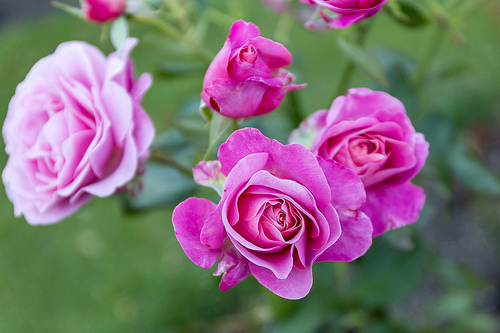

In [6]:
roses = list(data_dir.glob('roses/*'))
PIL.Image.open(str(roses[0]))

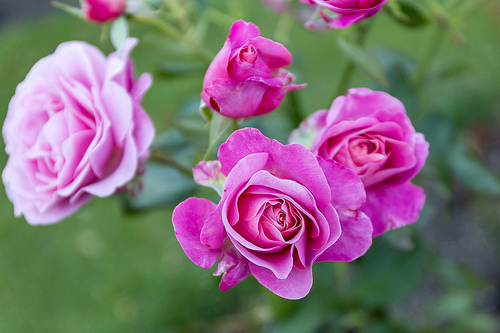

In [7]:
roses = list(data_dir.glob('roses/*'))
PIL.Image.open(str(roses[0]))

## keras.preprocessing을 사용하여 로드하기

[image_dataset_from_directory](https://www.tensorflow.org/api_docs/python/tf/keras/preprocessing/image_dataset_from_directory)를 사용하여 이들 이미지를 디스크에 로드해 보겠습니다.

참고: 이 섹션에 소개된 Keras Preprocesing 유틸리티 및 레이어는 현재 실험 중이며 변경될 수 있습니다.

### 데이터세트 만들기

로더를 위해 일부 매개변수를 정의합니다.

In [8]:
batch_size = 32
img_height = 180
img_width = 180

모델을 개발할 때 검증 분할을 사용하는 것이 좋습니다. 훈련에 이미지의 80%를 사용하고 검증에 20%를 사용합니다.

In [9]:
train_ds = tf.keras.preprocessing.image_dataset_from_directory(
  data_dir,
  validation_split=0.2,
  subset="training",
  seed=123,
  image_size=(img_height, img_width),
  batch_size=batch_size)

Found 3670 files belonging to 5 classes.
Using 2936 files for training.


In [10]:
val_ds = tf.keras.preprocessing.image_dataset_from_directory(
  data_dir,
  validation_split=0.2,
  subset="validation",
  seed=123,
  image_size=(img_height, img_width),
  batch_size=batch_size)

Found 3670 files belonging to 5 classes.
Using 734 files for validation.


이러한 데이터세트의 `class_names` 속성에서 클래스 이름을 찾을 수 있습니다.

In [11]:
class_names = train_ds.class_names
print(class_names)

['daisy', 'dandelion', 'roses', 'sunflowers', 'tulips']


### 데이터 시각화하기

훈련 데이터세트의 처음 9개 이미지는 다음과 같습니다.

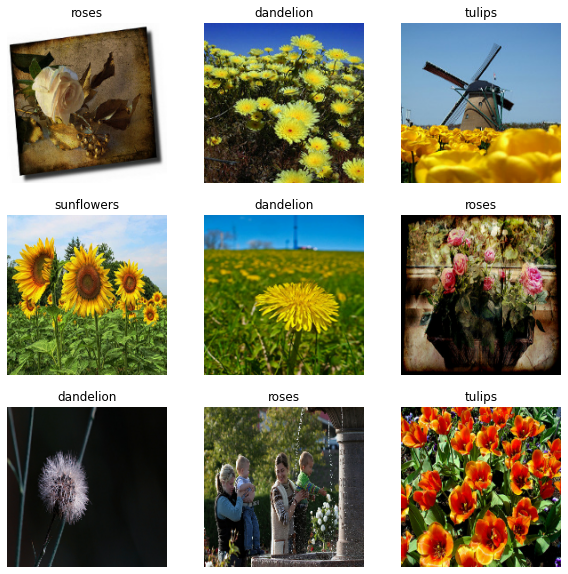

In [12]:
import matplotlib.pyplot as plt

plt.figure(figsize=(10, 10))
for images, labels in train_ds.take(1):
  for i in range(9):
    ax = plt.subplot(3, 3, i + 1)
    plt.imshow(images[i].numpy().astype("uint8"))
    plt.title(class_names[labels[i]])
    plt.axis("off")

이러한 데이터세트를 사용하는 모델을 `model.fit`(이 튜토리얼의 뒷부분에 표시)에 전달하여 모델을 훈련할 수 있습니다. 원하는 경우, 데이터세트를 수동으로 반복하고 이미지 배치를 검색할 수도 있습니다.

In [13]:
for image_batch, labels_batch in train_ds:
  print(image_batch.shape)
  print(labels_batch.shape)
  break

(32, 180, 180, 3)
(32,)


`image_batch`는 형상 `(32, 180, 180, 3)`의 텐서입니다. 이것은 형상 `180x180x3`의 32개 이미지 배치입니다(마지막 치수는 색상 채널 RGB를 나타냄). `label_batch`는 형상 `(32,)`의 텐서이며 32개 이미지에 해당하는 레이블입니다.


참고: 이들 텐서 중 하나에서 `.numpy()`를 호출하여 `numpy.ndarray`로 변환할 수 있습니다.

### 데이터 표준화하기


RGB 채널 값은 `[0, 255]` 범위에 있습니다. 신경망에는 이상적이지 않습니다. 일반적으로 입력 값을 작게 만들어야 합니다. 여기서는 Rescaling 레이어를 사용하여 값이 `[0, 1]`에 있도록 표준화합니다.

In [14]:
from tensorflow.keras import layers

normalization_layer = tf.keras.layers.experimental.preprocessing.Rescaling(1./255)

이 레이어를 사용하는 방법에는 두 가지가 있습니다. map을 호출하여 데이터세트에 레이어를 적용할 수 있습니다.

In [15]:
normalized_ds = train_ds.map(lambda x, y: (normalization_layer(x), y))
image_batch, labels_batch = next(iter(normalized_ds))
first_image = image_batch[0]
# Notice the pixels values are now in `[0,1]`.
print(np.min(first_image), np.max(first_image)) 

0.0 0.96902645


또는 모델 정의 내에 레이어를 포함하여 배포를 단순화할 수 있습니다. 여기서는 두 번째 접근 방식을 사용할 것입니다.

참고: 픽셀 값을 `[-1,1]`으로 조정하려면 대신 `Rescaling(1./127.5, offset=-1)`를 작성할 수 있습니다.

참고: 이전에 `image_dataset_from_directory`의 `image_size` 인수를 사용하여 이미지 크기를 조정했습니다. 모델에 크기 조정 논리를 포함하려면 [Resizing](https://www.tensorflow.org/api_docs/python/tf/keras/layers/experimental/preprocessing/Resizing) 레이어를 대신 사용할 수 있습니다.


### 성능을 위한 데이터세트 구성하기

버퍼링된 프리페치를 사용하여 I/O가 차단되지 않고 디스크에서 데이터를 생성할 수 있도록 합니다. 데이터를 로드할 때 사용해야 하는 두 가지 중요한 메서드입니다.

`.cache()`는 첫 번째 epoch 동안 디스크에서 이미지를 로드한 후 이미지를 메모리에 유지합니다. 이렇게 하면 모델을 훈련하는 동안 데이터세트가 병목 상태가 되지 않습니다. 데이터세트가 너무 커서 메모리에 맞지 않는 경우, 이 메서드를 사용하여 성능이 높은 온디스크 캐시를 생성할 수도 있습니다.

`.prefetch()`는 훈련 중에 데이터 전처리 및 모델 실행과 겹칩니다.

관심 있는 독자는 [데이터 성능 가이드](https://www.tensorflow.org/guide/data_performance#prefetching)에서 두 가지 메서드와 디스크에 데이터를 캐시하는 방법에 대해 자세히 알아볼 수 있습니다.

In [16]:
AUTOTUNE = tf.data.experimental.AUTOTUNE

train_ds = train_ds.cache().prefetch(buffer_size=AUTOTUNE)
val_ds = val_ds.cache().prefetch(buffer_size=AUTOTUNE)

### 모델 훈련하기

완전성을 위해 준비한 데이터세트를 사용하여 간단한 모델을 훈련하는 방법을 보여줍니다. 이 모델은 어떤 식으로든 조정되지 않았습니다. 목표는 방금 만든 데이터세트를 사용하여 역학을 보여주는 것입니다. 이미지 분류에 대한 자세한 내용은 이 [튜토리얼](https://www.tensorflow.org/tutorials/images/classification)을 참조하세요.

In [17]:
num_classes = 5

model = tf.keras.Sequential([
  layers.experimental.preprocessing.Rescaling(1./255),
  layers.Conv2D(32, 3, activation='relu'),
  layers.MaxPooling2D(),
  layers.Conv2D(32, 3, activation='relu'),
  layers.MaxPooling2D(),
  layers.Conv2D(32, 3, activation='relu'),
  layers.MaxPooling2D(),
  layers.Flatten(),
  layers.Dense(128, activation='relu'),
  layers.Dense(num_classes)
])

In [18]:
model.compile(
  optimizer='adam',
  loss=tf.losses.SparseCategoricalCrossentropy(from_logits=True),
  metrics=['accuracy'])

참고: 몇 가지 epoch에 대해서만 훈련하므로 이 튜토리얼은 빠르게 진행됩니다. 

In [19]:
model.fit(
  train_ds,
  batch_size=batch_size,
  validation_data=val_ds,
  epochs=3
)

Epoch 1/3


 1/92 [..............................] - ETA: 4:11 - loss: 1.6197 - accuracy: 0.1562

 3/92 [..............................] - ETA: 3s - loss: 1.6387 - accuracy: 0.1701  

 4/92 [>.............................] - ETA: 4s - loss: 1.6328 - accuracy: 0.1725

 5/92 [>.............................] - ETA: 4s - loss: 1.6301 - accuracy: 0.1718

 6/92 [>.............................] - ETA: 4s - loss: 1.6292 - accuracy: 0.1701

 7/92 [=>............................] - ETA: 4s - loss: 1.6274 - accuracy: 0.1713

 8/92 [=>............................] - ETA: 4s - loss: 1.6251 - accuracy: 0.1748

 9/92 [=>............................] - ETA: 4s - loss: 1.6222 - accuracy: 0.1824

10/92 [==>...........................] - ETA: 4s - loss: 1.6190 - accuracy: 0.1894

11/92 [==>...........................] - ETA: 4s - loss: 1.6152 - accuracy: 0.1965

12/92 [==>...........................] - ETA: 4s - loss: 1.6100 - accuracy: 0.2044

13/92 [===>..........................] - ETA: 4s - loss: 1.6050 - accuracy: 0.2120

14/92 [===>..........................] - ETA: 4s - loss: 1.5994 - accuracy: 0.2193

15/92 [===>..........................] - ETA: 4s - loss: 1.5937 - accuracy: 0.2261

16/92 [====>.........................] - ETA: 4s - loss: 1.5876 - accuracy: 0.2326

17/92 [====>.........................] - ETA: 4s - loss: 1.5824 - accuracy: 0.2381

18/92 [====>.........................] - ETA: 4s - loss: 1.5768 - accuracy: 0.2432

19/92 [=====>........................] - ETA: 4s - loss: 1.5712 - accuracy: 0.2480

20/92 [=====>........................] - ETA: 4s - loss: 1.5662 - accuracy: 0.2523

21/92 [=====>........................] - ETA: 4s - loss: 1.5614 - accuracy: 0.2565

22/92 [======>.......................] - ETA: 4s - loss: 1.5562 - accuracy: 0.2604

23/92 [======>.......................] - ETA: 4s - loss: 1.5511 - accuracy: 0.2641

24/92 [======>.......................] - ETA: 4s - loss: 1.5471 - accuracy: 0.2674

25/92 [=======>......................] - ETA: 4s - loss: 1.5434 - accuracy: 0.2704

26/92 [=======>......................] - ETA: 3s - loss: 1.5396 - accuracy: 0.2735

27/92 [=======>......................] - ETA: 3s - loss: 1.5358 - accuracy: 0.2766

28/92 [========>.....................] - ETA: 3s - loss: 1.5319 - accuracy: 0.2797

29/92 [========>.....................] - ETA: 3s - loss: 1.5283 - accuracy: 0.2827

30/92 [========>.....................] - ETA: 3s - loss: 1.5248 - accuracy: 0.2855

31/92 [=========>....................] - ETA: 3s - loss: 1.5214 - accuracy: 0.2882

32/92 [=========>....................] - ETA: 3s - loss: 1.5180 - accuracy: 0.2909

33/92 [=========>....................] - ETA: 3s - loss: 1.5144 - accuracy: 0.2935

34/92 [==========>...................] - ETA: 3s - loss: 1.5109 - accuracy: 0.2958

36/92 [==========>...................] - ETA: 3s - loss: 1.5040 - accuracy: 0.3003

37/92 [===========>..................] - ETA: 3s - loss: 1.5005 - accuracy: 0.3027

38/92 [===========>..................] - ETA: 3s - loss: 1.4971 - accuracy: 0.3050

39/92 [===========>..................] - ETA: 3s - loss: 1.4938 - accuracy: 0.3072

40/92 [============>.................] - ETA: 3s - loss: 1.4905 - accuracy: 0.3094

41/92 [============>.................] - ETA: 3s - loss: 1.4872 - accuracy: 0.3115

42/92 [============>.................] - ETA: 3s - loss: 1.4840 - accuracy: 0.3136

43/92 [=============>................] - ETA: 2s - loss: 1.4807 - accuracy: 0.3156

44/92 [=============>................] - ETA: 2s - loss: 1.4776 - accuracy: 0.3176

45/92 [=============>................] - ETA: 2s - loss: 1.4745 - accuracy: 0.3196

46/92 [==============>...............] - ETA: 2s - loss: 1.4716 - accuracy: 0.3214

47/92 [==============>...............] - ETA: 2s - loss: 1.4687 - accuracy: 0.3233

48/92 [==============>...............] - ETA: 2s - loss: 1.4660 - accuracy: 0.3251

49/92 [==============>...............] - ETA: 2s - loss: 1.4633 - accuracy: 0.3269

50/92 [===============>..............] - ETA: 2s - loss: 1.4606 - accuracy: 0.3287

51/92 [===============>..............] - ETA: 2s - loss: 1.4580 - accuracy: 0.3303

52/92 [===============>..............] - ETA: 2s - loss: 1.4556 - accuracy: 0.3319

53/92 [================>.............] - ETA: 2s - loss: 1.4532 - accuracy: 0.3334

54/92 [================>.............] - ETA: 2s - loss: 1.4508 - accuracy: 0.3349

55/92 [================>.............] - ETA: 2s - loss: 1.4485 - accuracy: 0.3364

56/92 [=================>............] - ETA: 2s - loss: 1.4462 - accuracy: 0.3378

57/92 [=================>............] - ETA: 2s - loss: 1.4439 - accuracy: 0.3391

58/92 [=================>............] - ETA: 2s - loss: 1.4418 - accuracy: 0.3404

59/92 [==================>...........] - ETA: 1s - loss: 1.4396 - accuracy: 0.3418

60/92 [==================>...........] - ETA: 1s - loss: 1.4375 - accuracy: 0.3431

61/92 [==================>...........] - ETA: 1s - loss: 1.4354 - accuracy: 0.3445

62/92 [===================>..........] - ETA: 1s - loss: 1.4332 - accuracy: 0.3459

63/92 [===================>..........] - ETA: 1s - loss: 1.4311 - accuracy: 0.3473

64/92 [===================>..........] - ETA: 1s - loss: 1.4290 - accuracy: 0.3487

65/92 [====================>.........] - ETA: 1s - loss: 1.4269 - accuracy: 0.3500

66/92 [====================>.........] - ETA: 1s - loss: 1.4249 - accuracy: 0.3513

67/92 [====================>.........] - ETA: 1s - loss: 1.4228 - accuracy: 0.3527

68/92 [=====================>........] - ETA: 1s - loss: 1.4207 - accuracy: 0.3540

69/92 [=====================>........] - ETA: 1s - loss: 1.4188 - accuracy: 0.3552

70/92 [=====================>........] - ETA: 1s - loss: 1.4168 - accuracy: 0.3564

71/92 [======================>.......] - ETA: 1s - loss: 1.4149 - accuracy: 0.3576

72/92 [======================>.......] - ETA: 1s - loss: 1.4129 - accuracy: 0.3588

73/92 [======================>.......] - ETA: 1s - loss: 1.4109 - accuracy: 0.3600

74/92 [=======================>......] - ETA: 1s - loss: 1.4089 - accuracy: 0.3612

75/92 [=======================>......] - ETA: 1s - loss: 1.4070 - accuracy: 0.3624

76/92 [=======================>......] - ETA: 0s - loss: 1.4052 - accuracy: 0.3636

77/92 [========================>.....] - ETA: 0s - loss: 1.4033 - accuracy: 0.3647

78/92 [========================>.....] - ETA: 0s - loss: 1.4015 - accuracy: 0.3659

79/92 [========================>.....] - ETA: 0s - loss: 1.3997 - accuracy: 0.3670

80/92 [=========================>....] - ETA: 0s - loss: 1.3980 - accuracy: 0.3681

81/92 [=========================>....] - ETA: 0s - loss: 1.3963 - accuracy: 0.3691

82/92 [=========================>....] - ETA: 0s - loss: 1.3946 - accuracy: 0.3702

83/92 [==========================>...] - ETA: 0s - loss: 1.3930 - accuracy: 0.3712

85/92 [==========================>...] - ETA: 0s - loss: 1.3898 - accuracy: 0.3732

90/92 [============================>.] - ETA: 0s - loss: 1.3822 - accuracy: 0.3780

92/92 [==============================] - ETA: 0s - loss: 1.3795 - accuracy: 0.3798

92/92 [==============================] - 10s 79ms/step - loss: 1.3782 - accuracy: 0.3806 - val_loss: 1.0508 - val_accuracy: 0.5926


Epoch 2/3
 1/92 [..............................] - ETA: 0s - loss: 1.1465 - accuracy: 0.5938

 6/92 [>.............................] - ETA: 0s - loss: 1.0744 - accuracy: 0.6025

11/92 [==>...........................] - ETA: 0s - loss: 1.0696 - accuracy: 0.5853

16/92 [====>.........................] - ETA: 0s - loss: 1.0607 - accuracy: 0.5801

21/92 [=====>........................] - ETA: 0s - loss: 1.0520 - accuracy: 0.5796

26/92 [=======>......................] - ETA: 0s - loss: 1.0435 - accuracy: 0.5824

31/92 [=========>....................] - ETA: 0s - loss: 1.0380 - accuracy: 0.5854

36/92 [==========>...................] - ETA: 0s - loss: 1.0329 - accuracy: 0.5875

41/92 [============>.................] - ETA: 0s - loss: 1.0282 - accuracy: 0.5892

46/92 [==============>...............] - ETA: 0s - loss: 1.0242 - accuracy: 0.5904

51/92 [===============>..............] - ETA: 0s - loss: 1.0222 - accuracy: 0.5904

56/92 [=================>............] - ETA: 0s - loss: 1.0209 - accuracy: 0.5903

61/92 [==================>...........] - ETA: 0s - loss: 1.0200 - accuracy: 0.5904

66/92 [====================>.........] - ETA: 0s - loss: 1.0187 - accuracy: 0.5910

71/92 [======================>.......] - ETA: 0s - loss: 1.0171 - accuracy: 0.5919

76/92 [=======================>......] - ETA: 0s - loss: 1.0153 - accuracy: 0.5928

81/92 [=========================>....] - ETA: 0s - loss: 1.0137 - accuracy: 0.5934

86/92 [===========================>..] - ETA: 0s - loss: 1.0125 - accuracy: 0.5939

91/92 [============================>.] - ETA: 0s - loss: 1.0116 - accuracy: 0.5941

92/92 [==============================] - 1s 12ms/step - loss: 1.0115 - accuracy: 0.5940 - val_loss: 0.9939 - val_accuracy: 0.5954


Epoch 3/3


 1/92 [..............................] - ETA: 0s - loss: 1.1151 - accuracy: 0.5000

 6/92 [>.............................] - ETA: 0s - loss: 0.9893 - accuracy: 0.6166

11/92 [==>...........................] - ETA: 0s - loss: 0.9651 - accuracy: 0.6299

16/92 [====>.........................] - ETA: 0s - loss: 0.9499 - accuracy: 0.6319

21/92 [=====>........................] - ETA: 0s - loss: 0.9372 - accuracy: 0.6342

26/92 [=======>......................] - ETA: 0s - loss: 0.9250 - accuracy: 0.6375

31/92 [=========>....................] - ETA: 0s - loss: 0.9172 - accuracy: 0.6409

36/92 [==========>...................] - ETA: 0s - loss: 0.9115 - accuracy: 0.6427

41/92 [============>.................] - ETA: 0s - loss: 0.9067 - accuracy: 0.6438

46/92 [==============>...............] - ETA: 0s - loss: 0.9025 - accuracy: 0.6448

51/92 [===============>..............] - ETA: 0s - loss: 0.9001 - accuracy: 0.6450

56/92 [=================>............] - ETA: 0s - loss: 0.8986 - accuracy: 0.6451

61/92 [==================>...........] - ETA: 0s - loss: 0.8979 - accuracy: 0.6451

66/92 [====================>.........] - ETA: 0s - loss: 0.8968 - accuracy: 0.6455

71/92 [======================>.......] - ETA: 0s - loss: 0.8954 - accuracy: 0.6460

76/92 [=======================>......] - ETA: 0s - loss: 0.8937 - accuracy: 0.6465

81/92 [=========================>....] - ETA: 0s - loss: 0.8924 - accuracy: 0.6469

86/92 [===========================>..] - ETA: 0s - loss: 0.8912 - accuracy: 0.6473

91/92 [============================>.] - ETA: 0s - loss: 0.8904 - accuracy: 0.6475

92/92 [==============================] - 1s 12ms/step - loss: 0.8902 - accuracy: 0.6475 - val_loss: 0.9492 - val_accuracy: 0.6349


참고: `model.fit`을 사용하는 대신 사용자 정의 훈련 루프를 작성할 수도 있습니다. 자세한 내용은 이 [튜토리얼](https://www.tensorflow.org/guide/keras/writing_a_training_loop_from_scratch)을 참조하세요.

검증 정확성이 훈련 정확성에 비해 낮으므로 모델이 과대적합되었음을 알 수 있습니다. 이 [튜토리얼](https://www.tensorflow.org/tutorials/keras/overfit_and_underfit)에서 과대적합 및 축소 방법에 대해 자세히 알아볼 수 있습니다.

## 미세 제어를 위해 tf.data 사용하기

위의 keras.preprocessing 유틸리티는 이미지의 디렉토리에서 `tf.data.Dataset`을 작성하는 편리한 방법입니다. 보다 세밀한 제어를 위해 `tf.data`을 사용하여 자체 입력 파이프라인을 작성할수 있습니다. 이 섹션에서는 이전에 다운로드한 zip 파일 경로부터 시작하여 이를 수행하는 방법을 보여줍니다.

In [20]:
list_ds = tf.data.Dataset.list_files(str(data_dir/'*/*'), shuffle=False)
list_ds = list_ds.shuffle(image_count, reshuffle_each_iteration=False)

In [21]:
for f in list_ds.take(5):
  print(f.numpy())

b'/home/kbuilder/.keras/datasets/flower_photos/daisy/9489270024_1b05f08492_m.jpg'
b'/home/kbuilder/.keras/datasets/flower_photos/sunflowers/14921668662_3ffc5b9db3_n.jpg'
b'/home/kbuilder/.keras/datasets/flower_photos/roses/15277801151_5ed88f40f0_n.jpg'
b'/home/kbuilder/.keras/datasets/flower_photos/sunflowers/18972803569_1a0634f398_m.jpg'
b'/home/kbuilder/.keras/datasets/flower_photos/tulips/19425920580_cdc8f49aed_n.jpg'


파일의 트리 구조를 사용하여 `class_names` 목록을 컴파일할 수 있습니다.

In [22]:
class_names = np.array(sorted([item.name for item in data_dir.glob('*') if item.name != "LICENSE.txt"]))
print(class_names)

['daisy' 'dandelion' 'roses' 'sunflowers' 'tulips']


데이터세트를 훈련 및 검증으로 분할합니다.

In [23]:
val_size = int(image_count * 0.2)
train_ds = list_ds.skip(val_size)
val_ds = list_ds.take(val_size)

다음과 같이 각 데이터세트의 길이를 볼 수 있습니다.

In [24]:
print(tf.data.experimental.cardinality(train_ds).numpy())
print(tf.data.experimental.cardinality(val_ds).numpy())

2936
734


파일 경로를 `(img, label)` 쌍으로 변환하는 간단한 함수를 작성합니다.

In [25]:
def get_label(file_path):
  # convert the path to a list of path components
  parts = tf.strings.split(file_path, os.path.sep)
  # The second to last is the class-directory
  one_hot = parts[-2] == class_names
  # Integer encode the label
  return tf.argmax(one_hot)

In [26]:
def decode_img(img):
  # convert the compressed string to a 3D uint8 tensor
  img = tf.image.decode_jpeg(img, channels=3)
  # resize the image to the desired size
  return tf.image.resize(img, [img_height, img_width])

In [27]:
def process_path(file_path):
  label = get_label(file_path)
  # load the raw data from the file as a string
  img = tf.io.read_file(file_path)
  img = decode_img(img)
  return img, label

`Dataset.map`을 사용하여 `image, label` 쌍의 데이터세트를 작성합니다.

In [28]:
# Set `num_parallel_calls` so multiple images are loaded/processed in parallel.
train_ds = train_ds.map(process_path, num_parallel_calls=AUTOTUNE)
val_ds = val_ds.map(process_path, num_parallel_calls=AUTOTUNE)

In [29]:
for image, label in train_ds.take(1):
  print("Image shape: ", image.numpy().shape)
  print("Label: ", label.numpy())

Image shape:  (180, 180, 3)
Label:  2


### 성능을 위한 데이터세트 구성하기

이 데이터세트로 모델을 훈련하려면 데이터에 대해 다음이 필요합니다.

- 잘 섞는다.
- 배치 처리한다.
- 가능한 빨리 배치를 사용할 수 있어야 한다.

이러한 기능은 `tf.data` API를 사용하여 추가할 수 있습니다. 자세한 내용은 [입력 파이프라인 성능](../../guide/performance/datasets) 가이드를 참조하세요.

In [30]:
def configure_for_performance(ds):
  ds = ds.cache()
  ds = ds.shuffle(buffer_size=1000)
  ds = ds.batch(batch_size)
  ds = ds.prefetch(buffer_size=AUTOTUNE)
  return ds

train_ds = configure_for_performance(train_ds)
val_ds = configure_for_performance(val_ds)

### 데이터 시각화하기

이 데이터세트를 이전에 작성한 데이터세트와 유사하게 시각화할 수 있습니다.

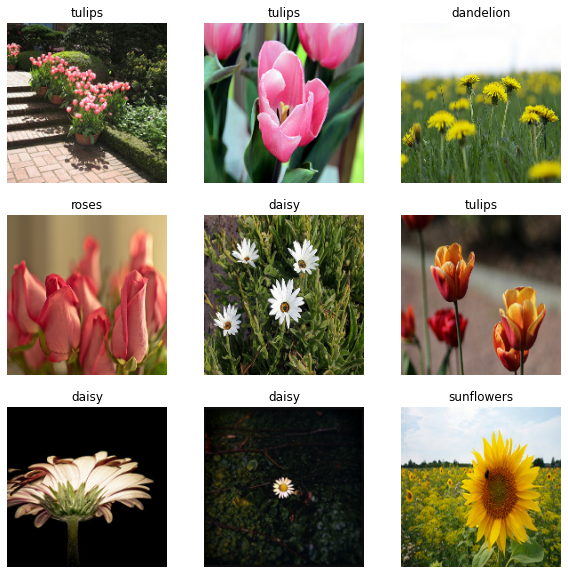

In [31]:
image_batch, label_batch = next(iter(train_ds))

plt.figure(figsize=(10, 10))
for i in range(9):
  ax = plt.subplot(3, 3, i + 1)
  plt.imshow(image_batch[i].numpy().astype("uint8"))
  label = label_batch[i]
  plt.title(class_names[label])
  plt.axis("off")

### 모델 계속 훈련하기

위의 `keras.preprocessing`에 의해 작성된 것과 유사한 `tf.data.Dataset`를 수동으로 빌드했습니다. 모델 훈련을 계속할 수 있습니다. 이전과 마찬가지로 실행 시간을 짧게 유지하기 위해 몇 가지 epoch 동안 훈련합니다.

In [32]:
model.fit(
  train_ds,
  validation_data=val_ds,
  epochs=3
)

Epoch 1/3


 1/92 [..............................] - ETA: 58s - loss: 0.6257 - accuracy: 0.8438

 4/92 [>.............................] - ETA: 1s - loss: 0.8454 - accuracy: 0.6562 

 8/92 [=>............................] - ETA: 1s - loss: 0.8226 - accuracy: 0.6602

11/92 [==>...........................] - ETA: 1s - loss: 0.8224 - accuracy: 0.6648

15/92 [===>..........................] - ETA: 1s - loss: 0.8114 - accuracy: 0.6750

19/92 [=====>........................] - ETA: 1s - loss: 0.8088 - accuracy: 0.6776

22/92 [======>.......................] - ETA: 1s - loss: 0.7973 - accuracy: 0.6790

26/92 [=======>......................] - ETA: 1s - loss: 0.7868 - accuracy: 0.6827

30/92 [========>.....................] - ETA: 1s - loss: 0.7972 - accuracy: 0.6771

33/92 [=========>....................] - ETA: 1s - loss: 0.7966 - accuracy: 0.6761

37/92 [===========>..................] - ETA: 0s - loss: 0.7967 - accuracy: 0.6723

40/92 [============>.................] - ETA: 0s - loss: 0.7874 - accuracy: 0.6812

43/92 [=============>................] - ETA: 0s - loss: 0.7940 - accuracy: 0.6817

47/92 [==============>...............] - ETA: 0s - loss: 0.7990 - accuracy: 0.6795

50/92 [===============>..............] - ETA: 0s - loss: 0.7951 - accuracy: 0.6787

54/92 [================>.............] - ETA: 0s - loss: 0.7967 - accuracy: 0.6811

58/92 [=================>............] - ETA: 0s - loss: 0.7884 - accuracy: 0.6853

62/92 [===================>..........] - ETA: 0s - loss: 0.7839 - accuracy: 0.6890

67/92 [====================>.........] - ETA: 0s - loss: 0.7807 - accuracy: 0.6898

72/92 [======================>.......] - ETA: 0s - loss: 0.7709 - accuracy: 0.6931

77/92 [========================>.....] - ETA: 0s - loss: 0.7777 - accuracy: 0.6895

82/92 [=========================>....] - ETA: 0s - loss: 0.7777 - accuracy: 0.6894

87/92 [===========================>..] - ETA: 0s - loss: 0.7785 - accuracy: 0.6907

92/92 [==============================] - ETA: 0s - loss: 0.7760 - accuracy: 0.6911

92/92 [==============================] - 3s 22ms/step - loss: 0.7760 - accuracy: 0.6911 - val_loss: 0.6896 - val_accuracy: 0.7548


Epoch 2/3
 1/92 [..............................] - ETA: 1s - loss: 0.8934 - accuracy: 0.6250

 6/92 [>.............................] - ETA: 0s - loss: 0.6231 - accuracy: 0.7812

11/92 [==>...........................] - ETA: 0s - loss: 0.6659 - accuracy: 0.7585

16/92 [====>.........................] - ETA: 0s - loss: 0.6437 - accuracy: 0.7695

21/92 [=====>........................] - ETA: 0s - loss: 0.6465 - accuracy: 0.7634

26/92 [=======>......................] - ETA: 0s - loss: 0.6471 - accuracy: 0.7584

31/92 [=========>....................] - ETA: 0s - loss: 0.6448 - accuracy: 0.7611

36/92 [==========>...................] - ETA: 0s - loss: 0.6514 - accuracy: 0.7569

41/92 [============>.................] - ETA: 0s - loss: 0.6275 - accuracy: 0.7675

46/92 [==============>...............] - ETA: 0s - loss: 0.6288 - accuracy: 0.7670

51/92 [===============>..............] - ETA: 0s - loss: 0.6241 - accuracy: 0.7714

56/92 [=================>............] - ETA: 0s - loss: 0.6210 - accuracy: 0.7706

61/92 [==================>...........] - ETA: 0s - loss: 0.6169 - accuracy: 0.7720

66/92 [====================>.........] - ETA: 0s - loss: 0.6162 - accuracy: 0.7732

71/92 [======================>.......] - ETA: 0s - loss: 0.6113 - accuracy: 0.7746

76/92 [=======================>......] - ETA: 0s - loss: 0.6072 - accuracy: 0.7759

81/92 [=========================>....] - ETA: 0s - loss: 0.6027 - accuracy: 0.7747

86/92 [===========================>..] - ETA: 0s - loss: 0.6031 - accuracy: 0.7743

91/92 [============================>.] - ETA: 0s - loss: 0.5998 - accuracy: 0.7761

92/92 [==============================] - 1s 14ms/step - loss: 0.6003 - accuracy: 0.7759 - val_loss: 0.7863 - val_accuracy: 0.7193


Epoch 3/3
 1/92 [..............................] - ETA: 1s - loss: 0.7333 - accuracy: 0.7500

 6/92 [>.............................] - ETA: 0s - loss: 0.5369 - accuracy: 0.8021

11/92 [==>...........................] - ETA: 0s - loss: 0.5176 - accuracy: 0.8153

16/92 [====>.........................] - ETA: 0s - loss: 0.4984 - accuracy: 0.8203

21/92 [=====>........................] - ETA: 0s - loss: 0.5241 - accuracy: 0.8080

26/92 [=======>......................] - ETA: 0s - loss: 0.5108 - accuracy: 0.8113

31/92 [=========>....................] - ETA: 0s - loss: 0.5049 - accuracy: 0.8115

36/92 [==========>...................] - ETA: 0s - loss: 0.5046 - accuracy: 0.8134

41/92 [============>.................] - ETA: 0s - loss: 0.4994 - accuracy: 0.8186

46/92 [==============>...............] - ETA: 0s - loss: 0.4834 - accuracy: 0.8274

51/92 [===============>..............] - ETA: 0s - loss: 0.4786 - accuracy: 0.8284

56/92 [=================>............] - ETA: 0s - loss: 0.4662 - accuracy: 0.8315

61/92 [==================>...........] - ETA: 0s - loss: 0.4604 - accuracy: 0.8356

66/92 [====================>.........] - ETA: 0s - loss: 0.4493 - accuracy: 0.8385

71/92 [======================>.......] - ETA: 0s - loss: 0.4523 - accuracy: 0.8371

76/92 [=======================>......] - ETA: 0s - loss: 0.4464 - accuracy: 0.8388

81/92 [=========================>....] - ETA: 0s - loss: 0.4427 - accuracy: 0.8410

86/92 [===========================>..] - ETA: 0s - loss: 0.4423 - accuracy: 0.8405

91/92 [============================>.] - ETA: 0s - loss: 0.4459 - accuracy: 0.8393

92/92 [==============================] - 1s 13ms/step - loss: 0.4454 - accuracy: 0.8396 - val_loss: 0.8220 - val_accuracy: 0.7153


## TensorFlow 데이터세트 사용하기

이 튜토리얼에서는 지금까지 디스크에서 데이터를 로드하는 데 중점을 두었습니다. [TensorFlow 데이터세트](https://www.tensorflow.org/datasets)에서 다운로드하기 쉬운 대규모 데이터세트 [카탈로그](https://www.tensorflow.org/datasets)를 탐색하여 사용할 데이터세트를 찾을 수도 있습니다. 이전에 Flowers 데이터세트를 디스크에서 로드했으므로 TensorFlow 데이터세트로 가져오는 방법을 살펴보겠습니다. 

TensorFlow 데이터세트를 사용하여 꽃 [데이터세트](https://www.tensorflow.org/datasets/catalog/tf_flowers)를 다운로드합니다.

In [33]:
(train_ds, val_ds, test_ds), metadata = tfds.load(
    'tf_flowers',
    split=['train[:80%]', 'train[80%:90%]', 'train[90%:]'],
    with_info=True,
    as_supervised=True,
)

꽃 데이터세트에는 5개의 클래스가 있습니다.

In [34]:
num_classes = metadata.features['label'].num_classes
print(num_classes)

5


데이터세트에서 이미지를 검색합니다.

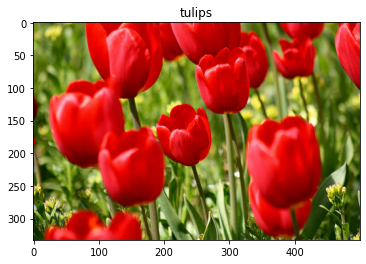

In [35]:
get_label_name = metadata.features['label'].int2str

image, label = next(iter(train_ds))
_ = plt.imshow(image)
_ = plt.title(get_label_name(label))

이전과 마찬가지로, 성능을 위해 각 데이터세트를 일괄 처리, 셔플 및 구성해야 합니다.

In [36]:
train_ds = configure_for_performance(train_ds)
val_ds = configure_for_performance(val_ds)
test_ds = configure_for_performance(test_ds)

[데이터 강화](https://www.tensorflow.org/tutorials/images/data_augmentation) 가이드를 방문하여 꽃 데이터세트 및 TensorFlow 데이터세트를 처리하는 전체 예제를 찾을 수 있습니다.

## 다음 단계

이 튜토리얼에서는 디스크에서 이미지를 로드하는 두 가지 방법을 보여주었습니다. 먼저 Keras 전처리 레이어 및 유틸리티를 사용하여 이미지 데이터세트를 로드하고 전처리하는 방법을 배웠습니다. 다음으로, tf.data를 사용하여 처음부터 입력 파이프라인을 작성하는 방법을 배웠습니다. 다음 단계로 이 [튜토리얼](https://www.tensorflow.org/tutorials/images/data_augmentation)을 방문하여 데이터 기능 보강을 추가하는 방법을 학습할 수 있습니다. tf.data에 대한 자세한 내용은 이 [가이드](https://www.tensorflow.org/guide/data)를 참조하세요.